In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import re
import nltk
from nltk.corpus import stopwords

In [2]:
tfidfvec = TfidfVectorizer()
LR = LogisticRegression()
trained = False

In [3]:
#Input is not-cleaned documents that are labeled 0 for fake and 1 for real
#must be dataframe with columns 'text' and 'label'
#This function cleans the text and tests the model
def test_pipeline(data):
    #ensure the model is trained first before using
    global tfidfvec
    global LR
    global trained
    if not trained:
        return 0
    #clean the text
    data['text'] = data['text'].apply(clean_text)
    #vectorize it
    xv = tfidfvec.transform(data['text'])
    #test the vector data against the label
    y_pred = LR.predict(xv)
    conf = confusion_matrix(y_pred, data['label'])
    score = LR.score(xv, data['label'])
    return conf, score

In [26]:
#Input is not-cleaned documents that are labeled 0 for fake and 1 for real
#must be dataframe with columns 'text' and 'label'
#This function cleans the text and trains the model
def train_pipeline(data):
    #if already trained once before, reset the model
    global tfidfvec
    global LR
    global trained
    if trained:
        tfidfvec = TfidfVectorizer()
        LR = LogisticRegression()
    #clean the text
    data['text'] = data['text'].apply(clean_text)
    #vectorize it
    xv = tfidfvec.fit_transform(data['text'])
    #fit the vector data to the label
    LR.fit(xv, data['label'])
    trained = True


In [5]:
#Function to get a query from our specific database and return it as a dataframe
def get_sql_data(query):
    # MySQL info
    config = {
        'user': 'project',
        'password': 'COMP541',
        'host': '150.230.44.118',
        'database': 'project'
    }
    #connect
    conn = mysql.connector.connect(**config)
    #read into dataframe
    data = pd.read_sql(query, conn)
    #close connection
    conn.close()
    return data

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
#clean text works on one document at a time so needs to be applied with .apply()
def clean_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Remove special characters and convert to lowercase
    clean_tokens = [re.sub(r'[^a-zA-Z\s]', '', token).lower() for token in tokens]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.add('said')
    stop_words.add('reuters')
    clean_tokens = [token for token in clean_tokens if token not in stop_words]
    # Join tokens back into a single string
    clean_text = ' '.join(clean_tokens)
    return clean_text


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dchur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dchur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#import training data
query = "SELECT `text`,`label` FROM `Tutorial`"
data = get_sql_data(query)
query = "SELECT `text` FROM `Articles` WHERE `source` LIKE '%New York Times%'"
nyt_data = get_sql_data(query)
#the nyt is highly trusted, it's label is always real
nyt_data['label'] = 1


#import testing data
query = "SELECT `text`,`label` FROM `Kaggle`"
kaggle = get_sql_data(query)
#sample for testing
#data = data.sample(1000)
# Invert the label column for Kaggle set
kaggle['label'] = kaggle['label'].map({0: 1, 1: 0})


#concat the nyt articles
data = pd.concat([data, nyt_data, kaggle], ignore_index=True)
#sample for testing
#data = data.sample(1000)

#split into test and train
data_train, data_test = train_test_split(data, test_size = 0.2)

C:\Users\dchur\AppData\Local\Temp\ipykernel_30932\1325120582.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)
C:\Users\dchur\AppData\Local\Temp\ipykernel_30932\1325120582.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


In [28]:
data.shape

(117429, 2)

In [8]:
train_pipeline(data_train)

In [19]:
cm, score = test_pipeline(data_test)

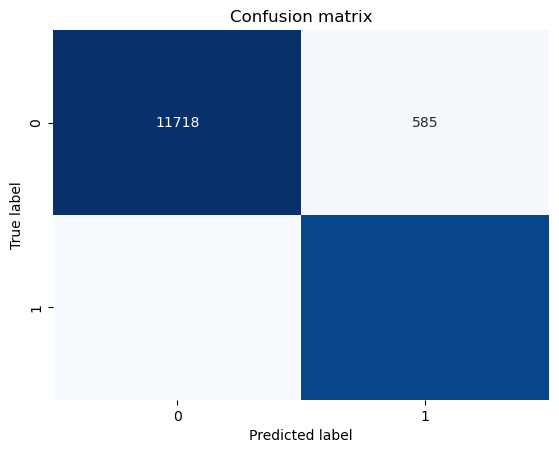

0.9576769139061568


array([[11718,   585],
       [  409, 10774]], dtype=int64)

In [21]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
print(score)
cm

In [25]:
#Determine if the text body is fake news or not. Must be trained first
#False = Fake News, True = Real News
#In the scheme of the data
def fake_news_detector(text):
    global tfidfvec
    global LR
    global trained
    if not trained:
        return False

    #clean the text just one this time so no .apply()
    text = clean_text(text)
    print(text)
    #put the text into a 1x1 dataframe for the model
    data = {
        'text': [text,]
    }
    #vectorize it
    xv = tfidfvec.transform(data['text'])
    #test the vector data against the label
    y_pred = LR.predict_proba(xv)
    print(y_pred)
    return bool(y_pred[0][0] < y_pred[0][1])

In [11]:
fake_news_story = """
Title: Scientists Discover Hidden Civilization on Mars

Article:

In a groundbreaking discovery that could reshape our understanding of the universe, scientists have reportedly found evidence of a hidden civilization on the surface of Mars. According to sources within NASA, recent satellite imagery has revealed sprawling structures resembling ancient cities, complete with roads, buildings, and even what appears to be a central hub.

Dr. Jane Smith, lead researcher on the project, described the findings as "nothing short of extraordinary." She believes that the structures are likely the remnants of an advanced civilization that thrived on Mars millions of years ago.

The discovery has sparked widespread excitement among astronomers and space enthusiasts, with many speculating about the possible implications for humanity. Some have even suggested that the existence of a past Martian civilization could support theories of ancient alien visitation.

However, skeptics have raised doubts about the validity of the findings, pointing to the lack of concrete evidence and the possibility of natural geological formations being mistaken for artificial structures. Critics argue that until further research is conducted, it's premature to jump to conclusions about the existence of a Martian civilization.

Despite the skepticism, Dr. Smith and her team remain confident in their discovery and are eager to continue exploring the mysteries of our neighboring planet.
"""

fake_news_detector(fake_news_story)

[[0.90382674 0.09617326]]


False

In [27]:
real_news_story = """
Title: SpaceX Successfully Launches Crewed Mission to International Space Station

Article:

In a historic achievement for space exploration, SpaceX, the private aerospace company founded by Elon Musk, successfully launched its Crew Dragon spacecraft carrying four astronauts to the International Space Station (ISS). The mission, named Crew-1, marks the first operational flight of SpaceX's Crew Dragon spacecraft as part of NASA's Commercial Crew Program.

The Crew-1 mission launched atop a Falcon 9 rocket from Kennedy Space Center's Launch Complex 39A in Florida. The spacecraft, named Resilience, is carrying astronauts Michael Hopkins, Victor Glover, Shannon Walker, and Soichi Noguchi – representing NASA and the Japan Aerospace Exploration Agency (JAXA).

Following a smooth ascent into orbit, the Crew Dragon spacecraft is scheduled to dock autonomously with the ISS approximately 27 hours after liftoff. The astronauts will spend approximately six months aboard the space station, conducting scientific research, performing maintenance tasks, and participating in spacewalks.

The success of the Crew-1 mission underscores the growing partnership between NASA and commercial spaceflight companies like SpaceX in advancing human space exploration. It also represents a significant milestone in NASA's efforts to resume crewed launches from American soil since the retirement of the Space Shuttle program in 2011.

SpaceX's ability to safely transport astronauts to and from the ISS is a crucial step towards realizing NASA's goal of sustainable human spaceflight beyond low Earth orbit, including missions to the Moon and Mars.

The successful launch of Crew-1 demonstrates the continued progress and capabilities of private-sector space companies in the pursuit of ambitious space exploration goals, ultimately benefiting scientific discovery and humanity's understanding of the cosmos.
"""
fake_news_detector(real_news_story)

title  spacex successfully launches crewed mission international space station article  historic achievement space exploration  spacex  private aerospace company founded elon musk  successfully launched crew dragon spacecraft carrying four astronauts international space station  iss   mission  named crew  marks first operational flight spacex crew dragon spacecraft part nasa commercial crew program  crew mission launched atop falcon  rocket kennedy space center launch complex florida  spacecraft  named resilience  carrying astronauts michael hopkins  victor glover  shannon walker  soichi noguchi  representing nasa japan aerospace exploration agency  jaxa   following smooth ascent orbit  crew dragon spacecraft scheduled dock autonomously iss approximately  hours liftoff  astronauts spend approximately six months aboard space station  conducting scientific research  performing maintenance tasks  participating spacewalks  success crew mission underscores growing partnership nasa commercia

True

In [13]:
political_news_article = """
Title: U.S. Congress Passes Bipartisan Infrastructure Investment and Jobs Act

Article:

In a rare display of bipartisan cooperation, the United States Congress has passed the Infrastructure Investment and Jobs Act, a landmark piece of legislation aimed at modernizing the nation's infrastructure and creating new employment opportunities. The bill, which received strong support from both Democrats and Republicans, represents a significant step forward in addressing the country's infrastructure needs.

The Infrastructure Investment and Jobs Act allocates approximately $1.2 trillion over the next decade to fund a wide range of infrastructure projects, including transportation, broadband internet, water systems, and renewable energy. The legislation also includes provisions to improve resilience to climate change, enhance cybersecurity, and promote equity and inclusion in infrastructure investments.

Key components of the bill include:

- $110 billion for roads, bridges, and major projects
- $66 billion for passenger and freight rail, including Amtrak
- $65 billion for broadband internet access expansion
- $55 billion for clean water and wastewater infrastructure
- $39 billion for public transit, including upgrades and modernization
- $7.5 billion for electric vehicle infrastructure
- $3.5 billion for climate resilience and adaptation measures

The Infrastructure Investment and Jobs Act garnered broad support from lawmakers across the political spectrum, with both Democrats and Republicans emphasizing the importance of investing in America's infrastructure to create jobs, stimulate economic growth, and improve the quality of life for all citizens. President [Insert Name] is expected to sign the bill into law, signaling a significant achievement for his administration and for bipartisan cooperation in Congress.

While the passage of the Infrastructure Investment and Jobs Act represents a major legislative victory, some critics have raised concerns about the bill's funding mechanisms and potential impact on the national debt. However, supporters argue that the long-term benefits of investing in infrastructure far outweigh the short-term costs, and that the bill's provisions are essential for addressing critical infrastructure challenges facing the nation.

The bipartisan passage of the Infrastructure Investment and Jobs Act underscores the importance of collaboration and compromise in addressing complex issues and advancing the national interest. Moving forward, the implementation of the legislation will be critical in delivering tangible benefits to communities across the country and ensuring a more resilient and prosperous future for all Americans.
"""
fake_news_detector(political_news_article)

[[0.32251872 0.67748128]]


True

In [14]:
fake_political_news_article = """
Title: Shocking Revelation: Government Insider Exposes Corruption Scandal at Highest Levels

Article:

In a bombshell revelation that has sent shockwaves through the nation's capital, a high-ranking government insider has come forward to expose a widespread corruption scandal at the highest levels of power. According to the whistleblower, who spoke on condition of anonymity, top officials within the administration have been involved in a complex web of bribery, kickbacks, and backroom deals aimed at enriching themselves at the expense of the American people.

The whistleblower alleges that the corruption extends to multiple government agencies and spans across various policy areas, including healthcare, environmental regulation, and national security. Shockingly, the whistleblower claims that efforts to investigate and prosecute the corruption have been thwarted by powerful political forces seeking to protect their own interests and maintain their grip on power.

The scandal has sparked outrage among lawmakers and citizens alike, with calls for a full-scale investigation and accountability for those implicated in the wrongdoing. Critics of the administration have seized on the revelations as evidence of systemic corruption and incompetence, calling for sweeping reforms to restore integrity and transparency to government.

However, supporters of the administration have dismissed the allegations as politically motivated attacks aimed at undermining the president and his agenda. They argue that the whistleblower is part of a deep state conspiracy seeking to sabotage the administration's efforts to enact positive change and deliver on its promises to the American people.

Despite the denials and deflections from the administration, the whistleblower's claims have reignited concerns about ethics and accountability in government. As calls for accountability grow louder, the nation braces for a potentially explosive showdown between those seeking truth and justice and those seeking to protect their own power and privilege.

Stay tuned for further developments as this shocking scandal continues to unfold, shaking the foundations of the nation's capital and testing the resilience of American democracy.
"""
fake_news_detector(fake_political_news_article)

[[0.84461035 0.15538965]]


False

In [15]:
onion = "NEW YORK—Emphasizing that it was their only option amid the rampant protests that had erupted on campus, Columbia University announced Monday that it had given students the option to finish classes from prison. “Given the current political turmoil and the many safety hazards it poses, all current students will be permitted to complete their semesters from the New York penitentiary system,” said Columbia University President Minouche Shafik, adding that in light of recent events, all members of the community were encouraged to attend lectures virtually from the comfort of their dark, windowless, 6-by-8-foot cell. “While we wish we could continue in-person learning, the best way to keep our university safe is to allow students, faculty, and staff to complete the last few weeks of the school from behind bars. Also, should students need, they will be permitted to accept their diplomas virtually, regardless of whether they are in the back of a police van, at Rikers Island, or in solitary confinement somewhere off the grid.” At press time, Shafik added that any student who had been beaten to death could, if need be, also complete classes from their morgue."

In [16]:
fake_news_detector(onion)

[[0.62587396 0.37412604]]


False

In [17]:
def read_file_as_string(file_path, encoding='utf-8'):
    with open(file_path, 'r', encoding=encoding) as file:
        file_contents = file.read()
    return file_contents.encode('utf-8')

# Example usage
file_path = 'Article.txt'
file_contents = read_file_as_string(file_path)
fake_news_detector(file_contents.decode('utf-8'))


[[0.83237857 0.16762143]]


False